In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os,sys
sys.path.append('drive/MyDrive/Training_cta/thesisba/')

In [ ]:
!pip install unidecode
!pip install scikit-network
!pip install textdistance
!pip install fasttext

In [4]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [49]:
import csv
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import fasttext
import os

import deduplication.dataprocessing.data_processing as dp

from deduplication.blocking.completeness_blocker import CompletenessBlocker
from deduplication.blocking.greedy_blocker import GreedyBlocker
from deduplication.blocking.train_pair_creator import TrainPairsCreator

from deduplication.similarity.edit_distance_similarity import EditDistanceSimilarity
from deduplication.similarity.siamese_lstm_similarity import SiameseLSTM
from deduplication.config import EMBEDDING_PATH
from deduplication.config import SAVED_MODELS_PATH
from deduplication.similarity.cross_attribute_token_alignment_similarity import CrossAttributeTokenAlignment


from deduplication.clustering.hierarchical_clustering import EntityClustering


from deduplication.deduplicator.cata_deduplicator import CataDeduplicator
from deduplication.deduplicator.rule_based_deduplicator import RuleBasedDeduplicator
from deduplication.deduplicator.siamese_deduplicator import SiameseDeduplicator

import deduplication.evaluating.evaluating as eva

In [57]:
path_data = "data/csv_example_messy_input.csv"
path_labels = "data/csv_example_input_with_true_ids.csv"
val_size = 0.2
test_size = 0.2
attribute_names=['site_name','address','zip']
amount_attribute_tokens=[10,8,2]

# Data exploration

In [170]:
df_elem = dp.reading_data_for_exploration(path_data, path_labels)

In [59]:
# Total entity mentions
Number_of_entity_mentions = len(df_elem)

# Total true entities
Number_of_entities = df_elem['true_id'].nunique()

# Number of characters
df_elem['total_characters'].describe()

# Number of tokens  
df_elem['total_tokens'].describe()

# Number of mentions per entity
df_elem['true_id'].value_counts().describe()

Text(0, 0.5, 'Frequency')

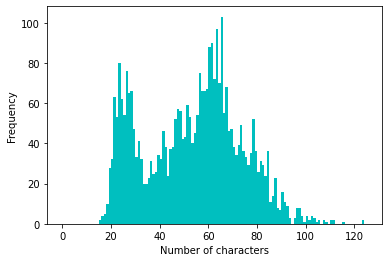

In [128]:
plot = df_elem['total_characters'].hist(bins=125,grid=False,range=[0,125],color='c')
plot.set_xlabel('Number of characters')
plot.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

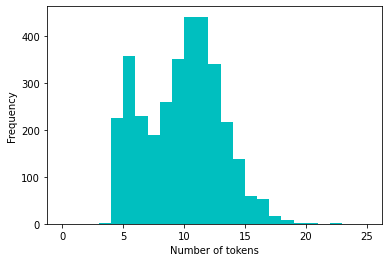

In [129]:
plot = df_elem['total_tokens'].hist(bins=25,grid=False,range=[0,25],color = 'c')
plot.set_xlabel('Number of tokens')
plot.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

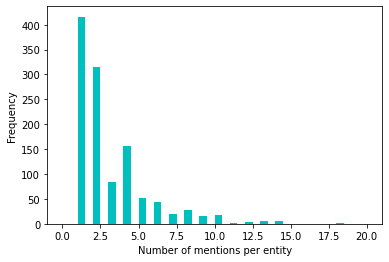

In [123]:
plot = df_elem['true_id'].value_counts().hist(bins=40,grid=False,range=[0,20], color = 'c')
plot.set_xlabel('Number of mentions per entity')
plot.set_ylabel('Frequency')

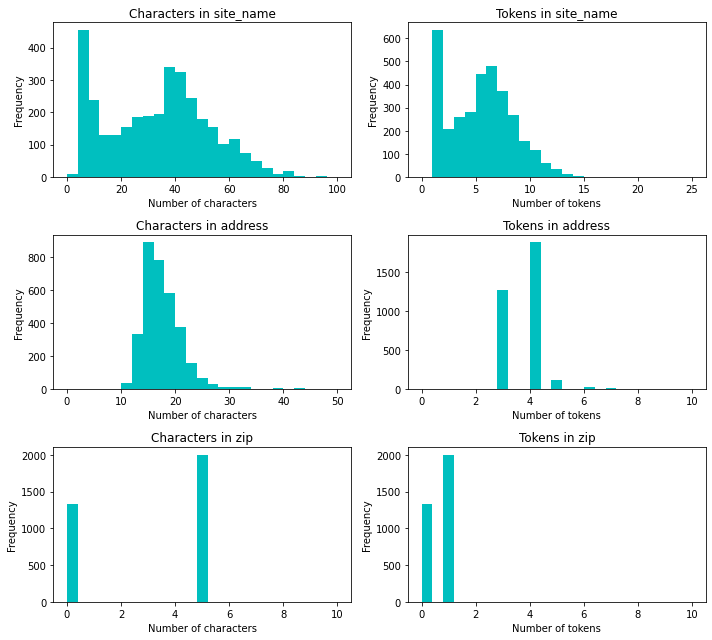

In [223]:
fig, axs = plt.subplots(3, 2,figsize = (10,9))
axs[0, 0].hist(df_elem['characters_site_name'],bins=25,range=[0,100],color = 'c')
axs[0, 0].set_title("Characters in site_name")
axs[0, 0].set_xlabel('Number of characters')
axs[0, 0].set_ylabel('Frequency')

axs[0, 1].hist(df_elem['tokens_site_name'],bins=25,range=[0,25],color = 'c')
axs[0, 1].set_title("Tokens in site_name")
axs[0, 1].set_xlabel('Number of tokens')
axs[0, 1].set_ylabel('Frequency')

axs[1, 0].hist(df_elem['characters_address'],bins=25,range=[0,50],color = 'c')
axs[1, 0].set_title("Characters in address")
axs[1, 0].set_xlabel('Number of characters')
axs[1, 0].set_ylabel('Frequency')


axs[1, 1].hist(df_elem['tokens_address'],bins=25,range=[0,10],color = 'c')
axs[1, 1].set_title("Tokens in address")
axs[1, 1].set_xlabel('Number of tokens')
axs[1, 1].set_ylabel('Frequency')

axs[2, 0].hist(df_elem['characters_zip'],bins=25,range=[0,10],color = 'c')
axs[2, 0].set_title("Characters in zip")
axs[2, 0].set_xlabel('Number of characters')
axs[2, 0].set_ylabel('Frequency')

axs[2, 1].hist(df_elem['tokens_zip'],bins=25,range=[0,10],color = 'c')
axs[2, 1].set_title("Tokens in zip")
axs[2, 1].set_xlabel('Number of tokens')
axs[2, 1].set_ylabel('Frequency')

fig.tight_layout()

# Train, validation and test split

In [58]:
train_set,val_set, test_set = dp.data_preparation(path_data,path_labels,val_size,test_size)
print('Number of clusters in training set: ', train_set['true_id'].nunique())
print('Number of entitiy mentions in training set:', len(train_set))
print('Number of clusters in validation set: ', val_set['true_id'].nunique())
print('Number of entity mentions in validation set: ', len(val_set))
print('Number of clusters in test set: ', test_set['true_id'].nunique())
print('Number of entity mentions in test set: ', len(test_set))

Number of clusters in training set:  697
Number of entitiy mentions in training set: 1949
Number of clusters in validation set:  232
Number of entity mentions in validation set:  750
Number of clusters in test set:  233
Number of entity mentions in test set:  638


# Blocking

Completeness blocker:

(Completeness threshold = 1.0)

Blocker based on combination of two blocking rules. Searches for the best combination. Advantage of this blocker is that entity mentions do not need to satisfy both selected blocking rules to eventually become clustered together. Therefore suffer less of 'hard' blocks.

In [59]:
completeness_blocker = CompletenessBlocker(attribute_names,completeness_threshold=1)
completeness_blocker.fit(train_set)

#selected blocking rules:
print(f"Blocking rule 1: {completeness_blocker.rule_1[0]} of {completeness_blocker.rule_1[1]}")
print(f"Blocking rule 2: {completeness_blocker.rule_2[0]} of {completeness_blocker.rule_2[1]}")

# Amount of pairwise comparisons for the validation set.
print('Number of entity mentions in validation set: ', len(val_set))
print('Number of naive pairwise comparisons: ', int(0.5*len(val_set)*(len(val_set)-1)))
validation_pairs = completeness_blocker.transform(val_set)
print('Number of pairwise comparisons for the validation set: ', len(validation_pairs))

# Completeness score on the validation set
df_results = completeness_blocker.extensive_metrics(val_set)
print("Completeness score for the validation set: ",np.round(df_results.loc[(df_results['rule 1'] == f"{completeness_blocker.rule_1[0]} of {completeness_blocker.rule_1[1]}") & (df_results['rule 2'] == f"{completeness_blocker.rule_2[0]} of {completeness_blocker.rule_2[1]}")]['completeness'].item(),5))
print("Homogeneity score for the validation set: ",np.round(df_results.loc[(df_results['rule 1'] == f"{completeness_blocker.rule_1[0]} of {completeness_blocker.rule_1[1]}") & (df_results['rule 2'] == f"{completeness_blocker.rule_2[0]} of {completeness_blocker.rule_2[1]}")]['homogeneity'].item(),5))
print("v-measure score for the validation set: ",np.round(df_results.loc[(df_results['rule 1'] == f"{completeness_blocker.rule_1[0]} of {completeness_blocker.rule_1[1]}") & (df_results['rule 2'] == f"{completeness_blocker.rule_2[0]} of {completeness_blocker.rule_2[1]}")]['v-measure'].item(),5))
print("Adjusted rand score for the validation set: ",np.round(df_results.loc[(df_results['rule 1'] == f"{completeness_blocker.rule_1[0]} of {completeness_blocker.rule_1[1]}") & (df_results['rule 2'] == f"{completeness_blocker.rule_2[0]} of {completeness_blocker.rule_2[1]}")]['adj_rand'].item(),5))

Blocking rule 1: first_token of site_name
Blocking rule 2: first_three_char of address
Number of entity mentions in validation set:  750
Number of naive pairwise comparisons:  280875
Number of pairwise comparisons for the validation set:  9455
Completeness score for the validation set:  0.99886
Homogeneity score for the validation set:  0.31671
v-measure score for the validation set:  0.48093
Adjusted rand score for the validation set:  0.0122


Greedy blocker:

(Completeness threshold = 0.98)

Blocker that greedily selects the blocking rule that minimizes the amount of comparisons that needs to be made. This is done until a given 'quality' threshold is reached. The completeness score is used to compute this quality. Is best used for large datasets, downside are the 'hard' blocks. Entity mentions can not get any connections outside of the blocks.

In [43]:
greedy_blocker = GreedyBlocker(attribute_names,completeness_threshold=0.99)
greedy_blocker.fit(train_set)

#selected blocking rules:
print(f"Blocking rules:")
for rule in greedy_blocker.rules:
      print(f"  - {rule[0]} of {rule[1]}")
        
# Amount of pairwise comparisons for the validation set.
print('Number of entity mentions in validation set: ', len(val_set))
print('Number of naive pairwise comparisons: ', int(0.5*len(val_set)*(len(val_set)-1)))

validation_pairs = greedy_blocker.transform(val_set)
print('Number of pairwise comparisons for the validation set: ', len(validation_pairs))

# Completeness score on the validation set
df_results = greedy_blocker.compute_metrics(val_set)


print("Completeness score for the validation set: ",np.round(df_results['completeness'].item(),5))
print("homogeneity score for the validation set: ",np.round(df_results['homogeneity'].item(),5))
print("v-measure score score for the validation set: ",np.round(df_results['v-measure'].item(),5))
print("Adjusted rand score score for the validation set: ",np.round(df_results['adj_rand'].item(),5))

    attribute                rule  number of comparisons  completeness
0   site_name  complete_attribute                 1053.0      0.891757
1   site_name         first_token                55296.0      0.943944
2   site_name          all_digits              1838499.0      0.871942
3   site_name    first_three_char                72064.0      0.943403
4   site_name  first_three_digits              1838499.0      0.871942
5     address  complete_attribute                 1024.0      0.890760
6     address         first_token                 4259.0      0.995596
7     address          all_digits                 3765.0      0.993082
8     address    first_three_char                 7430.0      0.997524
9     address  first_three_digits                 7578.0      0.997514
10        zip  complete_attribute               315505.0      0.827864
11        zip         first_token               315505.0      0.827864
12        zip          all_digits               315505.0      0.827864
13    

Pairs for the test set:

In [60]:
test_pairs = completeness_blocker.transform(test_set)

# Amount of pairwise comparisons for the test set.
print('Number of entity mentions in test set: ', len(test_set))
print('Number of naive pairwise comparisons: ', int(0.5*len(test_set)*(len(test_set)-1)))
print('Number of pairwise comparisons for the test set: ', len(test_pairs))

# Completeness score on the validation set
df_results = completeness_blocker.extensive_metrics(test_set)
print("Completeness score for the test set: ",np.round(df_results.loc[(df_results['rule 1'] == f"{completeness_blocker.rule_1[0]} of {completeness_blocker.rule_1[1]}") & (df_results['rule 2'] == f"{completeness_blocker.rule_2[0]} of {completeness_blocker.rule_2[1]}")]['completeness'].item(),5))
print("Homogeneity score for the test set: ",np.round(df_results.loc[(df_results['rule 1'] == f"{completeness_blocker.rule_1[0]} of {completeness_blocker.rule_1[1]}") & (df_results['rule 2'] == f"{completeness_blocker.rule_2[0]} of {completeness_blocker.rule_2[1]}")]['homogeneity'].item(),5))
print("v-measure score for the test set: ",np.round(df_results.loc[(df_results['rule 1'] == f"{completeness_blocker.rule_1[0]} of {completeness_blocker.rule_1[1]}") & (df_results['rule 2'] == f"{completeness_blocker.rule_2[0]} of {completeness_blocker.rule_2[1]}")]['v-measure'].item(),5))
print("Adjusted rand score for the test set: ",np.round(df_results.loc[(df_results['rule 1'] == f"{completeness_blocker.rule_1[0]} of {completeness_blocker.rule_1[1]}") & (df_results['rule 2'] == f"{completeness_blocker.rule_2[0]} of {completeness_blocker.rule_2[1]}")]['adj_rand'].item(),5))

Number of entity mentions in test set:  638
Number of naive pairwise comparisons:  203203
Number of pairwise comparisons for the test set:  7208
Completeness score for the test set:  1.0
Homogeneity score for the test set:  0.42199
v-measure score for the test set:  0.59352
Adjusted rand score for the test set:  0.01994


# Creating training and validation pairs for model training

Selects the pairs that are going to be used for training and validation, with a match/non-match ratio of 50/50

In [7]:
train_pair_creator = TrainPairsCreator()
train_pairs = train_pair_creator.transform(train_set)
print('Number of pairwise comparisons for the training set: ', len(train_pairs))

val_pairs = train_pair_creator.transform(val_set)
print('Number of pairwise comparisons for the validation set: ', len(val_pairs))

Number of pairwise comparisons for the training set:  7344
Number of pairwise comparisons for the validation set:  3644


In [117]:
training_pairs

index_1_index                                  index_1_site_name  \
0              1062                                            hamline   
1              1382  one hope united (delegate) bridgeport child de...   
2              2082              chicago public schools ward, laura s.   
3              2153                           el valor little tykes ii   
4               140                    healing temple - healing temple   
...             ...                                                ...   
7339            261                 el hogar del ni?o loomis preschool   
7340           1009                                              healy   
7341            327                              kove learning academy   
7342            119  centers for new horizons - edison l. hoard lea...   
7343           1721             gads hill center kove learning academy   

          index_1_address index_1_zip index_1_phone index_1_true_id  \
0          4747 s. bishop                   5354565            4747   
1     3053 s. normal ave.       60616       8425566       305360616   
2       410 n. monticello       60624       5346440        41060624   
3     1723 w. 35th street       60609       5791791       172360609   
4      4941 w chicago ave                   2876964       494160651   
...                   ...         ...           ...             ...   
7339       1718 s. loomis                   5630662       171860608   
7340      3040 s. parnell                   5349170       304060616   
7341  3137 w. 71st street                   4763083       313760629   
7342      3901 s state st                   5362187       390160609   
7343       3137 w 71st st       60629       4763083       313760629   

      index_2_index                                  index_2_site_name  \
0              2868                       albany park community center   
1              3013  one hope united - bridgeport child development...   
2              2827                                        ward, laura   
3              2690                                   north avenue i/t   
4               298  el valor corporation-carlos cantu children and...   
...             ...                                                ...   
7339            594  el hogar del nino/cuidar - el hogar del nino/e...   
7340           2618                                              lewis   
7341           1362                  streator child development center   
7342            352           centers for new horizons edison l. hoard   
7343           2174             gads hill center kove learning academy   

                  index_2_address index_2_zip index_2_phone index_2_true_id  \
0               3401 west ainslie       60625       5395907       340160625   
1          3053 south normal ave.       60616       8425566       305360616   
2               410 n. monticello       60624       5346440        41060624   
3              2001 w. pierce st.       60622       3424499       200160622   
4                 2434 s. kildare                   7219311       243460623   
...                           ...         ...           ...             ...   
7339           1718 s loomis blvd                   5639796       171860608   
7340           1431 n. leamington       60651       5343060       143160651   
7341  405 chicago street streator       61364       6724350        40561364   
7342         3901 s. state street                   5362187       390160609   
7343              3137 w 71st st.       60629       4763083       313760629   

      label  
0         0  
1         1  
2         1  
3         0  
4         0  
...     ...  
7339      1  
7340      0  
7341      0  
7342      1  
7343      1  

[7344 rows x 13 columns]

# Rule based Similarity

    - Computes entity mentions similarity by token based comparison with the Levenshtein/Hamming/Jaro-Winkler distance.  

In [107]:
edit_distance_sim = EditDistanceSimilarity(attribute_names)

In [132]:
similarity_scores = edit_distance_sim.transform(val_pairs)

In [136]:
similarity_scores[similarity_scores['index_1_index'] ==1191]

index_1_index                         index_1_site_name  \
909            1191  gads hill center - sinai community/ogden   
924            1191  gads hill center - sinai community/ogden   
965            1191  gads hill center - sinai community/ogden   
994            1191  gads hill center - sinai community/ogden   
1158           1191  gads hill center - sinai community/ogden   
1810           1191  gads hill center - sinai community/ogden   
1830           1191  gads hill center - sinai community/ogden   
2100           1191  gads hill center - sinai community/ogden   
2882           1191  gads hill center - sinai community/ogden   
2956           1191  gads hill center - sinai community/ogden   
3234           1191  gads hill center - sinai community/ogden   
3286           1191  gads hill center - sinai community/ogden   

       index_1_address index_1_zip index_1_phone index_1_true_id  \
909   2653 w ogden ave                   5211196       265360608   
924   2653 w ogden ave                   5211196       265360608   
965   2653 w ogden ave                   5211196       265360608   
994   2653 w ogden ave                   5211196       265360608   
1158  2653 w ogden ave                   5211196       265360608   
1810  2653 w ogden ave                   5211196       265360608   
1830  2653 w ogden ave                   5211196       265360608   
2100  2653 w ogden ave                   5211196       265360608   
2882  2653 w ogden ave                   5211196       265360608   
2956  2653 w ogden ave                   5211196       265360608   
3234  2653 w ogden ave                   5211196       265360608   
3286  2653 w ogden ave                   5211196       265360608   

     index_1_group_id index_1_group_id2 index_1_group_id_combined  \
909               265                                         265   
924               265                                         265   
965               265                                         265   
994               265                                         265   
1158              265                                         265   
1810              265                                         265   
1830              265                                         265   
2100              265                                         265   
2882              265                                         265   
2956              265                                         265   
3234              265                                         265   
3286              265                                         265   

      index_1_new_id  ... index_2_new_id  \
909                0  ...              0   
924                0  ...              0   
965                0  ...              0   
994                0  ...              0   
1158               0  ...              0   
1810               0  ...              0   
1830               0  ...              0   
2100               0  ...              0   
2882               0  ...              0   
2956               0  ...              0   
3234               0  ...              0   
3286               0  ...              0   

                             index_2_embedded_site_name  \
909   [[-0.030468499287962914, -0.16956740617752075,...   
924   [[-0.030468499287962914, -0.16956740617752075,...   
965   [[-0.030468499287962914, -0.16956740617752075,...   
994   [[-0.030468499287962914, -0.16956740617752075,...   
1158  [[-0.030468499287962914, -0.16956740617752075,...   
1810  [[-0.07175001502037048, 0.03182221204042435, -...   
1830  [[0.008531644940376282, -0.02668830379843712, ...   
2100  [[0.012180919, -0.02093976, -0.033675466, 0.01...   
2882  [[-0.030468499287962914, -0.16956740617752075,...   
2956  [[-0.030468499287962914, -0.16956740617752075,...   
3234  [[-0.010679523460566998, -0.05587267503142357,...   
3286  [[-0.030468499287962914, -0.16956740617752075,...   

                               index

In [134]:
df_metrics = eva.score_matching_methods('Rule_based_similarity',similarity_scores)
df_metrics

Accuracy  Precision    Recall
Rule_based_similarity  0.931394   0.998099  0.864435

In [135]:
similarity_scores['right_prediction'] = similarity_scores['label'] == similarity_scores['match']
wrong_predictions = similarity_scores[similarity_scores['right_prediction'] == False].sample(1)
print(wrong_predictions['index_1_site_name'].item())
print(wrong_predictions['index_1_address'].item())
print(wrong_predictions['index_2_zip'].item())
print(wrong_predictions['index_2_site_name'].item())
print(wrong_predictions['index_2_address'].item())
print(wrong_predictions['index_2_zip'].item())

goudy
5120 n. winthrop
60640
south-east asia center
5120 n broadway avenue
60640


In [123]:
wrong_predictions

index_1_index                                  index_1_site_name  \
498             15  catholic charities of the archdiocese of chica...   

    index_1_address index_1_zip index_1_phone index_1_true_id  \
498   1100 s may st                   6663787       110060607   

    index_1_group_id index_1_group_id2 index_1_group_id_combined  \
498              110                                         110   

     index_1_new_id  ... index_2_new_id  \
498               0  ...              0   

                            index_2_embedded_site_name  \
498  [[0.012180918827652931, -0.02093975991010666, ...   

                              index_2_embedded_address  \
498  [[-0.010967562906444073, 0.017772231251001358,...   

                                  index_2_embedded_zip label similarity_score  \
498  [[-0.05792864412069321, -0.0657229945063591, 0...     1         0.315789   

     match wrong_predicition wrong_prediction right_prediction  
498  False              True             True            False  

[1 rows x 32 columns]

In [109]:
indices = test_set['index'].to_numpy()
hier_clustering = EntityClustering(indices)

df_clusters = hier_clustering.transform(similarity_scores)

In [110]:
df_results = eva.score('Rule_based_deduplicator',test_set, df_clusters)
df_results

Number of clusters  Adjusted Rand Index  Homogeneity  \
Rule_based_deduplicator                 251             0.885737     0.988167   

                         completeness  v_measure  Accuracy  Precision  \
Rule_based_deduplicator      0.974963    0.98152  0.998775   0.901578   

                           Recall   F1score  True positives  False positives  \
Rule_based_deduplicator  0.871634  0.886353           971.0            106.0   

                         False negatives  True negatives  
Rule_based_deduplicator            143.0        201983.0

# Siamese LSTM Similarity


    - The model utilizes a Siamese Bidirectional Long Short-Term Memory network and the Exponential Negative Manhattan Distance to compute the similarity between entity mentions.  

In [8]:
siamese_lstm_sim = SiameseLSTM(attribute_names,patience=50)

In [9]:
siamese_lstm_sim.fit(train_pairs,val_pairs)

Epoch 1/500
230/230 [==============================] - 38s 165ms/step - loss: 0.0977 - accuracy: 0.8946 - val_loss: 0.0990 - val_accuracy: 0.8746
Epoch 2/500
230/230 [==============================] - 34s 147ms/step - loss: 0.0783 - accuracy: 0.9120 - val_loss: 0.0953 - val_accuracy: 0.8836
Epoch 3/500
230/230 [==============================] - 34s 147ms/step - loss: 0.0710 - accuracy: 0.9190 - val_loss: 0.0896 - val_accuracy: 0.8927
Epoch 4/500
230/230 [==============================] - 33s 144ms/step - loss: 0.0655 - accuracy: 0.9321 - val_loss: 0.0864 - val_accuracy: 0.8880
Epoch 5/500
230/230 [==============================] - 35s 153ms/step - loss: 0.0609 - accuracy: 0.9434 - val_loss: 0.0773 - val_accuracy: 0.9166
Epoch 6/500
230/230 [==============================] - 35s 150ms/step - loss: 0.0555 - accuracy: 0.9547 - val_loss: 0.0713 - val_accuracy: 0.9193
Epoch 7/500
230/230 [==============================] - 35s 150ms/step - loss: 0.0523 - accuracy: 0.9619 - val_loss: 0.0668 -

Epoch 57/500
230/230 [==============================] - 35s 152ms/step - loss: 0.0160 - accuracy: 0.9946 - val_loss: 0.0413 - val_accuracy: 0.9635
Epoch 58/500
230/230 [==============================] - 37s 160ms/step - loss: 0.0159 - accuracy: 0.9948 - val_loss: 0.0440 - val_accuracy: 0.9544
Epoch 59/500
230/230 [==============================] - 37s 160ms/step - loss: 0.0155 - accuracy: 0.9944 - val_loss: 0.0431 - val_accuracy: 0.9588
Epoch 60/500
230/230 [==============================] - 33s 143ms/step - loss: 0.0158 - accuracy: 0.9948 - val_loss: 0.0416 - val_accuracy: 0.9542
Epoch 61/500
230/230 [==============================] - 32s 138ms/step - loss: 0.0150 - accuracy: 0.9951 - val_loss: 0.0424 - val_accuracy: 0.9561
Epoch 62/500
230/230 [==============================] - 35s 152ms/step - loss: 0.0150 - accuracy: 0.9950 - val_loss: 0.0426 - val_accuracy: 0.9550
Epoch 63/500
230/230 [==============================] - 35s 150ms/step - loss: 0.0150 - accuracy: 0.9952 - val_loss: 0

In [128]:
df_test = pd.DataFrame(siamese_lstm_sim.lstm_model.history.history)
df_test.to_pickle("./dummy.pkl")

In [132]:
n_runs = 5

for i in range(0,n_runs):
    siamese_lstm_sim = SiameseLSTM(attribute_names,n_epochs=3)
    siamese_lstm_sim.fit(train_pairs,val_pairs)
    df_hist = pd.DataFrame(siamese_lstm_sim.lstm_model.history.history)
    df_hist.to_pickle("./siameselstm_run" + str(i) + ".pkl")

Epoch 1/3
230/230 [==============================] - 40s 172ms/step - loss: 0.0992 - accuracy: 0.8893 - val_loss: 0.1066 - val_accuracy: 0.8611
Epoch 2/3
230/230 [==============================] - 46s 200ms/step - loss: 0.0770 - accuracy: 0.9108 - val_loss: 0.0985 - val_accuracy: 0.8784
Epoch 3/3
230/230 [==============================] - 43s 187ms/step - loss: 0.0702 - accuracy: 0.9243 - val_loss: 0.0942 - val_accuracy: 0.8825
Epoch 1/3
230/230 [==============================] - 47s 203ms/step - loss: 0.0965 - accuracy: 0.8915 - val_loss: 0.0994 - val_accuracy: 0.8806
Epoch 2/3
230/230 [==============================] - 40s 174ms/step - loss: 0.0757 - accuracy: 0.9163 - val_loss: 0.0929 - val_accuracy: 0.8845
Epoch 3/3
230/230 [==============================] - 50s 218ms/step - loss: 0.0685 - accuracy: 0.9236 - val_loss: 0.0824 - val_accuracy: 0.9012
Epoch 1/3
230/230 [==============================] - 54s 234ms/step - loss: 0.0975 - accuracy: 0.8928 - val_loss: 0.1094 - val_accuracy:

In [22]:
n_runs = 10
results = [pd.read_pickle("./pickle_files_1/pickle_files/siameselstm_run" + str(i) + ".pkl") for i in range(0,n_runs)]


In [48]:
results_loss = {}
results_acc = {}
results_val_loss = {}
results_val_acc = {}
accuracy = []
for i in range(0,n_runs):
    df = pd.read_pickle("./pickle_files_1/pickle_files/siameselstm_run" + str(i) + ".pkl")
    #print(df)
    results_loss['loss_'+ str(i)] = df['loss'].head(160)
    results_acc['accuracy_'+ str(i)] = df['accuracy'].head(160)
    results_val_loss['val_loss_'+ str(i)] = df['val_loss'].head(160)
    results_val_acc['val_accuracy_'+ str(i)] = df['val_accuracy'].head(160)
    accuracy.append(max(df['val_accuracy']))

df_results_loss = pd.DataFrame(results_loss)
df_results_acc = pd.DataFrame(results_acc)
df_results_val_loss = pd.DataFrame(results_val_loss)
df_results_val_acc = pd.DataFrame(results_val_acc)


In [54]:
loss_mean = df_results_loss.mean(axis=1)
loss_std = df_results_loss.std(axis=1)
acc_mean = df_results_acc.mean(axis=1)
acc_std = df_results_acc.std(axis=1)
val_loss_mean = df_results_val_loss.mean(axis=1)
val_loss_std = df_results_val_loss.std(axis=1)
val_acc_mean = df_results_val_acc.mean(axis=1)
val_acc_std = df_results_val_acc.std(axis=1)

In [46]:
print('Average accuracy on the validation pairs: ', np.round(np.mean(accuracy),4))
print('Standard deviation of the accuracy on the validation pairs: ', np.round(np.std(accuracy),4))

Average accuracy on the validation pairs:  0.9605
Standard deviation of the accuracy on the validation pairs:  0.0082


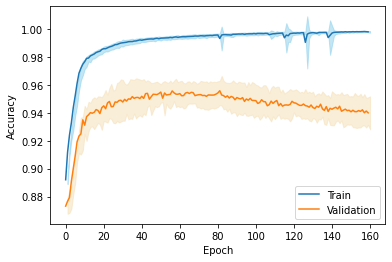

In [96]:
plt.plot(acc_mean)
plt.plot(val_acc_mean)
plt.fill_between(np.arange(1, len(acc_mean)+1), 
                        acc_mean + acc_std, 
                        acc_mean - acc_std,
                        color = 'skyblue', alpha=0.5)
plt.fill_between(np.arange(1, len(val_acc_mean)+1), 
                        val_acc_mean + val_acc_std, 
                        val_acc_mean - val_acc_std,
                        color = 'wheat', alpha=0.5)
#plt.title('SiamLSTM Accuracy over 10 runs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

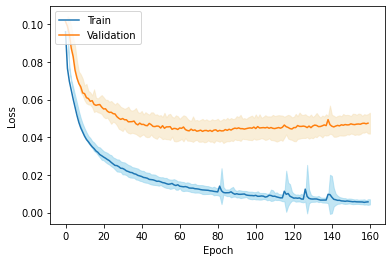

In [97]:
plt.plot(loss_mean)
plt.plot(val_loss_mean)
plt.fill_between(np.arange(1, len(loss_mean)+1), 
                        loss_mean + loss_std, 
                        loss_mean - loss_std,
                        color = 'skyblue', alpha=0.5)
plt.fill_between(np.arange(1, len(val_loss_mean)+1), 
                        val_loss_mean + val_loss_std, 
                        val_loss_mean - val_loss_std,
                        color = 'wheat', alpha=0.5)
#plt.title('SiamLSTM Loss over 10 runs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

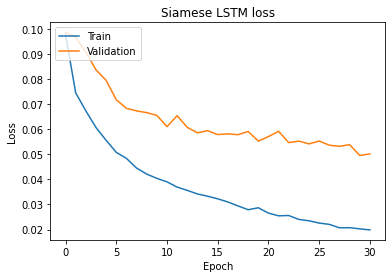

In [152]:
plt.plot(siamese_lstm_sim.lstm_model.history.history['loss'])
plt.plot(siamese_lstm_sim.lstm_model.history.history['val_loss'])
plt.title('Siamese LSTM loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [10]:
similarity_scores = siamese_lstm_sim.predict(test_pairs)

In [11]:
df_metrics = eva.score_matching_methods('siamese_lstm_similarity',similarity_scores)
df_metrics

Accuracy  Precision    Recall
siamese_lstm_similarity  0.979745   0.948308  0.917273

In [12]:
indices = test_set['index'].to_numpy()
hier_clustering = EntityClustering(indices)

df_clusters = hier_clustering.transform(similarity_scores)

In [13]:
df_results = eva.score('siamese_lstm_deduplicator',test_set, df_clusters)
df_results

Number of clusters  Adjusted Rand Index  \
siamese_lstm_deduplicator                 251             0.946893   

                           Homogeneity  completeness  v_measure  Accuracy  \
siamese_lstm_deduplicator     0.997651      0.983293    0.99042  0.999444   

                           Precision    Recall   F1score  True positives  \
siamese_lstm_deduplicator   0.988293  0.909336  0.947172          1013.0   

                           False positives  False negatives  True negatives  
siamese_lstm_deduplicator             12.0            101.0        202077.0

# Cross attribute token alignment similarity

    - The model utilizes FastText word embeddings, a Gated Recurrent Unit layer to incorporate contextual information
      and tries to match tokens across all attributes.

In [178]:
attribute_names=['title','length','artist','album','year']
amount_attribute_tokens=[10,2,2,7,1]
cata_sim = CrossAttributeTokenAlignment(attribute_names,amount_attribute_tokens=amount_attribute_tokens,batch_size=256,patience = 20)

cata_sim.load_model(SAVED_MODELS_PATH)



Exception ignored in: <function ScopedTFGraph.__del__ at 0x0000021DFAF7A288>
Traceback (most recent call last):
  File "C:\Users\Floris\Anaconda3\envs\ThesisBA\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 54, in __del__
    self.deleter(self.graph)
KeyboardInterrupt


KeyboardInterrupt: 

In [62]:
ft = fasttext.load_model(EMBEDDING_PATH)
training_entity_mentions = cata_sim.create_fasttext_embeddings(ft, train_set.copy())
validation_entity_mentions = cata_sim.create_fasttext_embeddings(ft,val_set.copy())
test_validation_entity_mentions = cata_sim.create_fasttext_embeddings(ft,test_set.copy())
del ft


train_pair_creator = TrainPairsCreator()
train_pairs = train_pair_creator.transform(training_entity_mentions)
print('Number of pairwise comparisons for the training set: ', len(train_pairs))

val_pairs = train_pair_creator.transform(validation_entity_mentions)
print('Number of pairwise comparisons for the training set: ', len(val_pairs))

test_pairs = completeness_blocker.transform(test_validation_entity_mentions)



Number of pairwise comparisons for the training set:  7344
Number of pairwise comparisons for the training set:  3644


In [189]:
cata_sim.fit(train_pairs,val_pairs)

Epoch 1/500


Exception ignored in: <function ScopedTFGraph.__del__ at 0x00000247D3111438>
Traceback (most recent call last):
  File "C:\Users\Floris\Anaconda3\envs\ThesisBA\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 54, in __del__
    self.deleter(self.graph)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
plt.plot(cata_sim.cata_model.history.history['accuracy'])
plt.plot(cata_sim.cata_model.history.history['val_accuracy'])
plt.title('Siamese LSTM accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(cata_sim.cata_model.history.history['loss'])
plt.plot(cata_sim.cata_model.history.history['val_loss'])
plt.title('Siamese LSTM loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [162]:
similarity_scores = cata_sim.predict(val_pairs)

In [163]:
df_metrics = eva.score_matching_methods('cata_similarity',similarity_scores)
df_metrics

Accuracy  Precision    Recall
cata_similarity  0.989297   0.985831  0.992865

In [164]:
similarity_scores['right_prediction'] = similarity_scores['label'] == similarity_scores['match']
wrong_predictions = similarity_scores[similarity_scores['right_prediction'] == False].sample(1)

In [65]:
indices = test_set['index'].to_numpy()
hier_clustering = EntityClustering(indices)

df_clusters = hier_clustering.transform(similarity_scores)

In [66]:
df_results = eva.score('cata_deduplicator',test_set, df_clusters)
df_results

Number of clusters  Adjusted Rand Index  Homogeneity  \
cata_deduplicator                 237             0.960035      0.99494   

                   completeness  v_measure  Accuracy  Precision    Recall  \
cata_deduplicator      0.991496   0.993215  0.999567   0.966364  0.954219   

                    F1score  True positives  False positives  False negatives  \
cata_deduplicator  0.960253          1063.0             37.0             51.0   

                   True negatives  
cata_deduplicator        202052.0

In [150]:
n_runs = 10
results_loss = {}
results_acc = {}
results_val_loss = {}
results_val_acc = {}
accuracy = []
for i in range(0,n_runs):
    df = pd.read_pickle("./pickle_files_3/cata_model_run" + str(i) + ".pkl")
    #print(df)
    results_loss['loss_'+ str(i)] = df['loss'].head(80)
    results_acc['accuracy_'+ str(i)] = df['accuracy'].head(80)
    results_val_loss['val_loss_'+ str(i)] = df['val_loss'].head(80)
    results_val_acc['val_accuracy_'+ str(i)] = df['val_accuracy'].head(80)
    accuracy.append(max(df['val_accuracy']))

df_results_loss = pd.DataFrame(results_loss)
df_results_acc = pd.DataFrame(results_acc)
df_results_val_loss = pd.DataFrame(results_val_loss)
df_results_val_acc = pd.DataFrame(results_val_acc)


In [151]:
loss_mean = df_results_loss.mean(axis=1)
loss_std = df_results_loss.std(axis=1)
acc_mean = df_results_acc.mean(axis=1)
acc_std = df_results_acc.std(axis=1)
val_loss_mean = df_results_val_loss.mean(axis=1)
val_loss_std = df_results_val_loss.std(axis=1)
val_acc_mean = df_results_val_acc.mean(axis=1)
val_acc_std = df_results_val_acc.std(axis=1)

In [153]:
print('Average accuracy on the validation pairs: ', np.round(np.mean(accuracy),4))
print('Standard deviation of the accuracy on the validation pairs: ', np.round(np.std(accuracy),4))

Average accuracy on the validation pairs:  0.9894
Standard deviation of the accuracy on the validation pairs:  0.0026


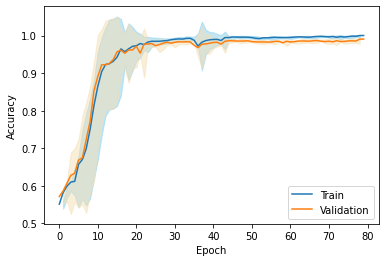

In [159]:
plt.plot(acc_mean)
plt.plot(val_acc_mean)
plt.fill_between(np.arange(1, len(acc_mean)+1), 
                        acc_mean + acc_std, 
                        acc_mean - acc_std,
                        color = 'skyblue', alpha=0.5)
plt.fill_between(np.arange(1, len(val_acc_mean)+1), 
                        val_acc_mean + val_acc_std, 
                        val_acc_mean - val_acc_std,
                        color = 'wheat', alpha=0.5)
#plt.title('SiamLSTM Accuracy over 10 runs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

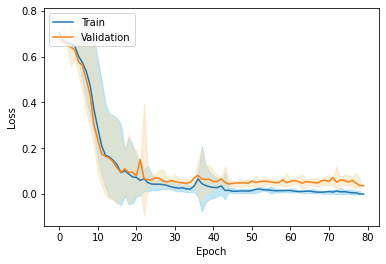

In [155]:
plt.plot(loss_mean)
plt.plot(val_loss_mean)
plt.fill_between(np.arange(1, len(loss_mean)+1), 
                        loss_mean + loss_std, 
                        loss_mean - loss_std,
                        color = 'skyblue', alpha=0.5)
plt.fill_between(np.arange(1, len(val_loss_mean)+1), 
                        val_loss_mean + val_loss_std, 
                        val_loss_mean - val_loss_std,
                        color = 'wheat', alpha=0.5)
#plt.title('SiamLSTM Loss over 10 runs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Cross token alignment GRU Deduplicator

    - The model utilizes FastText word embeddings, a Gated Recurrent Unit layer to incorporate contextual information
      and tries to match tokens across all attributes.  

In [ ]:
cata_deduplicator = CataDeduplicator(attribute_names)

In [ ]:
cata_deduplicator.fit(x_train=train_set,x_val = val_set)

In [ ]:
df_clusters = cata_deduplicator.predict(test_set)

In [ ]:
df_results = eva.score('Cata deduplicator',test_set, df_clusters)
df_results

# Rule based Deduplicator

    - Computes entity mentions similarity by token based comparison with the Levenshtein/Hamming/Jaro-Winkler distance.  
      

In [1]:
rule_base_deduplicator = RuleBasedDeduplicator(attribute_names)

NameError: name 'RuleBasedDeduplicator' is not defined

In [7]:
rule_base_deduplicator.fit(x_train=train_set)

Start fitting deduplicator model
Blocking rules:
First rule: first_token of site_name
Second rule: first_three_char of address
Done fitting deduplicator model
Fitting deduplicator model took: 0:00:02.462452


In [8]:
df_rl_clusters = rule_base_deduplicator.predict(test_set)

Start predicting
Amount of pairwise comparisons: 7208
Done predicting clusters with deduplicator model
Predicting took: 0:00:16.314911


In [9]:
df_results = eva.score('Rule based deduplicator',test_set, df_rl_clusters)
df_results

Number of clusters  Adjusted Rand Index  Homogeneity  \
Rule based deduplicator                 251             0.885737     0.988167   

                         completeness  v_measure  Accuracy  Precision  \
Rule based deduplicator      0.974963    0.98152  0.998775   0.901578   

                           Recall   F1score  True positives  False positives  \
Rule based deduplicator  0.871634  0.886353           971.0            106.0   

                         False negatives  True negatives  
Rule based deduplicator            143.0        201983.0

# Siamese LSTM Deduplicator


    - The model utilizes a two Long Short-Term Memory layers with shared weights and the Exponential Negative Manhattan
      Distance to compute the similarity between entity mentions.  

In [ ]:
siamese_deduplicator = SiameseDeduplicator(attribute_names)

In [ ]:
siamese_deduplicator.fit(train_set,val_set)

In [ ]:
df_sl_clusters = siamese_deduplicator.predict(test_set)

In [ ]:
df_results = eva.score('Siamese LSTM deduplicator',test_set, df_sl_clusters)
df_results